## What is Classification? (with mtcars)


## Setup and Imports

In [7]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [8]:

from plotnine import *
import statsmodels.api as sm

In [9]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [42]:
%%R

# My commonly used R imports

require('tidyverse')
require('DescTools')
require('ggrepel')

R[write to console]: Loading required package: ggrepel



## Load the data

read mtcars

In [22]:
from plotnine.data import mtcars
mtcars.head()

,name,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


## Logistic Regression 

What is the probability that a car is automatic or manual given it's weight and horsepower? 

In other words: `am ~ wt + hp`

In [28]:
%%R 

logistic <- glm(am ~ wt + hp, data = mtcars, family = binomial(link = 'logit'))
print(summary(logistic))
print(exp(coef(logistic)))
print(PseudoR2(logistic, which = 'McFadden'))


Call:
glm(formula = am ~ wt + hp, family = binomial(link = "logit"), 
    data = mtcars)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2537  -0.1568  -0.0168   0.1543   1.3449  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept) 18.86630    7.44356   2.535  0.01126 * 
wt          -8.08348    3.06868  -2.634  0.00843 **
hp           0.03626    0.01773   2.044  0.04091 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 43.230  on 31  degrees of freedom
Residual deviance: 10.059  on 29  degrees of freedom
AIC: 16.059

Number of Fisher Scoring iterations: 8

 (Intercept)           wt           hp 
1.561455e+08 3.085967e-04 1.036921e+00 
 McFadden 
0.7673104 


Oh look, a pseudo r^2 of .76. That's pretty good.

But now, what if our goal was prediction, not inference. Suppose I don't care much about how these things are related to one another. I just want to build a machine that categorizes cars as automatic or manual.

Visually, this is what we're doing

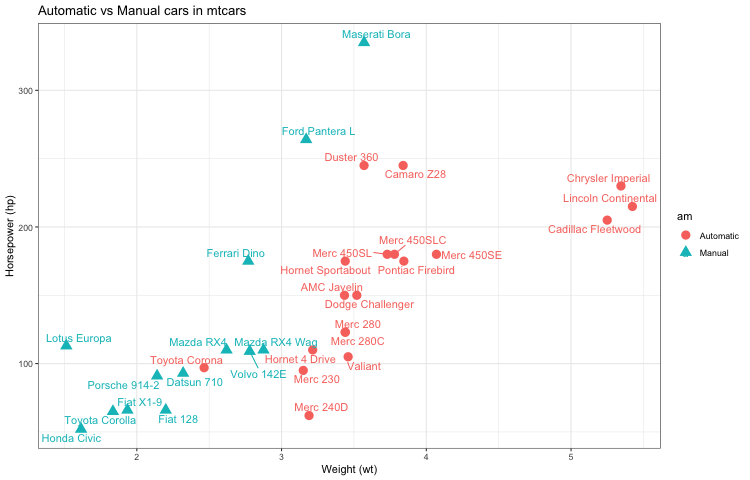

In [48]:
%%R -w 750 -i mtcars

mtcars$am <- factor(mtcars$am, labels = c('Automatic', 'Manual'))

ggplot(mtcars) +
    aes(x=wt, y=hp, color=am, shape=am, label=name) +
    geom_point(size=4) + 
    geom_text_repel() +
    theme_bw() + 
    labs(
        title="Automatic vs Manual cars in mtcars",
        y = "Horsepower (hp)", x= "Weight (wt)")

What is a classification task? The idea is to train an algorithm that will a boundary between the two categories and categorize any new data that comes in accurately. 

![](flashcards/Classification_web.png)

## The logistic regression is a classifier!!!

or...well...it can become one

In [37]:
%%R 

df <- mtcars %>% mutate(
    prediction_odds = exp(predict(logistic)),
    prediction_pct = prediction_odds / (1 + prediction_odds),
    prediction = ifelse(prediction_pct > 0.5, 'Manual', 'Automatic')
)

df %>% head()

                   mpg cyl disp  hp drat    wt  qsec vs        am gear carb
Mazda RX4         21.0   6  160 110 3.90 2.620 16.46  0    Manual    4    4
Mazda RX4 Wag     21.0   6  160 110 3.90 2.875 17.02  0    Manual    4    4
Datsun 710        22.8   4  108  93 3.85 2.320 18.61  1    Manual    4    1
Hornet 4 Drive    21.4   6  258 110 3.08 3.215 19.44  1 Automatic    3    1
Hornet Sportabout 18.7   8  360 175 3.15 3.440 17.02  0 Automatic    3    2
Valiant           18.1   6  225 105 2.76 3.460 20.22  1 Automatic    3    1
                  prediction_odds prediction_pct prediction
Mazda RX4             5.342583344    0.842335537     Manual
Mazda RX4 Wag         0.680058222    0.404782533  Automatic
Datsun 710           32.603078929    0.970240822     Manual
Hornet 4 Drive        0.043545086    0.041728035  Automatic
Hornet Sportabout     0.074561828    0.069388122  Automatic
Valiant               0.005013165    0.004988159  Automatic


In [50]:
%%R -o df

df %>% select(wt, hp, prediction, am) %>% head()

                     wt  hp prediction        am
Mazda RX4         2.620 110     Manual    Manual
Mazda RX4 Wag     2.875 110  Automatic    Manual
Datsun 710        2.320  93     Manual    Manual
Hornet 4 Drive    3.215 110  Automatic Automatic
Hornet Sportabout 3.440 175  Automatic Automatic
Valiant           3.460 105  Automatic Automatic


## How well did our classifier do?

In [51]:
pd.crosstab(df.prediction, df.am)

am,1,2
prediction,,
Automatic,18,1
Manual,1,12
